inceptionV3 Model Accuracy Adam softmax : 71.83%

https://medium.com/analytics-vidhya/transfer-learning-using-inception-v3-for-image-classification-86700411251b 

https://github.com/tejanirla/image_classification/blob/master/transfer_learning.ipynb

In [ ]:
# Import the inception model  
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras import layers 


In [ ]:
!pip install livelossplot
from livelossplot.inputs.keras import PlotLossesCallback

In [ ]:
pre_trained_model = InceptionV3(input_shape = (400, 400, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')
BATCH_SIZE = 64

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.959):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense (5, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 199, 199, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 199, 199, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
train_data_dir = "/content/drive/MyDrive/Colab Notebooks/preTestingDataSethdy/train"
test_data_dir = "/content/drive/MyDrive/Colab Notebooks/preTestingDataSethdy/test"
class_subset = ['AtopicDermatitis', 'lupus', 'PityriasisRosea', 'Psoriasis', 'Urticaria']

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   validation_split=0.10,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen =  ImageDataGenerator
( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = BATCH_SIZE,
                                                    classes=class_subset,
                                                    class_mode = 'categorical',
                                                    subset='training', 
                                                    target_size = (400, 400))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  train_datagen.flow_from_directory( train_data_dir,
                                                          batch_size  = BATCH_SIZE,
                                                          class_mode  = 'categorical',
                                                          classes=class_subset,
                                                          subset='validation',
                                                          target_size = (400, 400))
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                             target_size=(400, 400),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size =1,
                                             shuffle=False,
                                             seed=42)

Found 1200 images belonging to 5 classes.
Found 130 images belonging to 5 classes.
Found 387 images belonging to 5 classes.


In [ ]:
n_steps =  train_generator.samples// BATCH_SIZE #train_datagen.samples
n_val_steps = validation_generator.samples // BATCH_SIZE #validation_generator.samples
n_epochs = 50

In [ ]:
plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='inceptionV3AdamSoftmax.weights.best.h5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


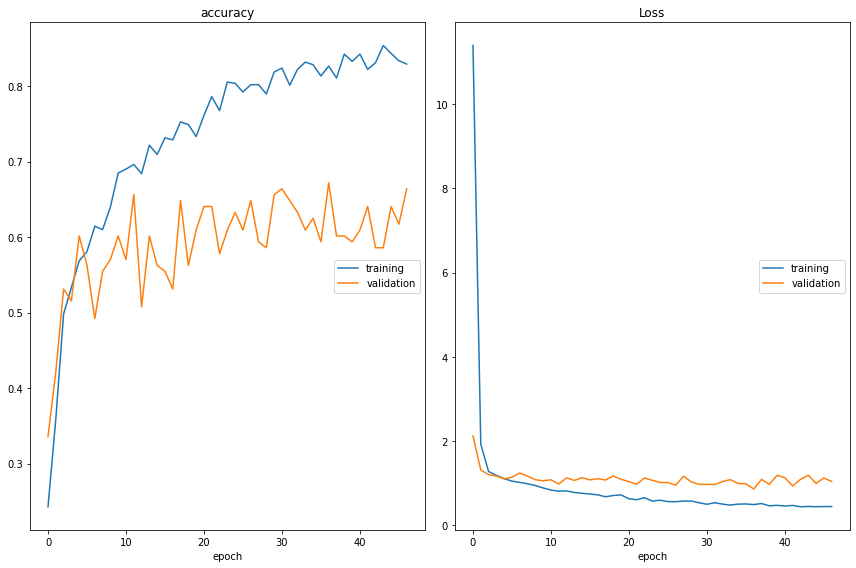

accuracy
	training         	 (min:    0.243, max:    0.854, cur:    0.829)
	validation       	 (min:    0.336, max:    0.672, cur:    0.664)
Loss
	training         	 (min:    0.444, max:   11.393, cur:    0.449)
	validation       	 (min:    0.865, max:    2.120, cur:    1.045)
18/18 [==============================] - 54s 3s/step - loss: 0.4494 - accuracy: 0.8292 - val_loss: 1.0452 - val_accuracy: 0.6641


In [ ]:
# callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = n_steps,
            epochs = n_epochs,
            validation_steps = n_val_steps,
            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
            verbose = 1
          )


לפי איך שנראה בגרף- אחוז דיוק של 70% 

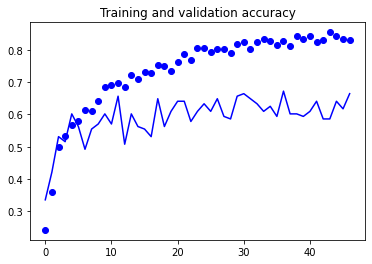

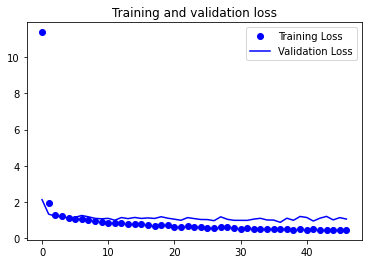

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Generate predictions
model.load_weights('inceptionV3AdamSoftmax.weights.best.h5') # initialize the best trained weights

true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
inception = model.predict(test_generator)
inc_pred_classes_ft = np.argmax(inception, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
inc_acc_ft = accuracy_score(true_classes, inc_pred_classes_ft)
print("inceptionV3 Model Accuracy Adam softmax : {:.2f}%".format(inc_acc_ft * 100))

inceptionV3 Model Accuracy Adam softmax : 71.83%


In [ ]:
print("Hi")

Hi


In [ ]:
print("תודה לה'")

תודה לה'


אוקי אז המודל שיש לנו פה הוא מוד שבנוי בעזרת TRANSFER LEARNIG של מודל אינקפשייןוי3



